In [ ]:
from pynq import Overlay, MMIO, lib
from pynq.lib.video import VideoMode
from PIL import Image
import cffi
from time import sleep

## Before starting this piece of code be sure that SW0 on board is in OFF position

In [ ]:
overlay = Overlay("wrapper_camera_pwm_GPIO_hdmi.xsa")

Class to manage the convolution filter mapped on FPGA. It provides method to modify "on fly" the kernel (7x7)

In [ ]:
class Convolution_Filter:
    def __init__(self, overlay, base_address=0x43C10000, address_range=0x10000, address_offset=0x40):
        self.base_address = base_address
        self.address_range = address_range
        self.address_offset = address_offset
        self.offset = 0x04
        self.mmio = MMIO(base_address, address_range)
        self.conv = overlay.filter.convolution_filter

    def update_filter(self, fil):
        if(len(fil) != 51):
            print("La lunghezza del filtro deve essere di 51 elementi")

        address = self.address_offset
        data = 0x00000000
        bits_shift = 0
        counter = 0

        for el in fil:
            if(bits_shift >= 32):
                self.mmio.write(address, data)
                data = 0x00000000
                bits_shift = 0
                address = address + self.offset

            counter += 1
            data = data | (el << bits_shift)
            bits_shift += 8
            if(counter >= 51):
                self.mmio.write(address, data)

    def print_filter(self):
        f1 = self.conv.mmio.array.view('int8')[0x40:0x71]
        f2 = self.conv.mmio.array.view('int8')[0x71:0x73]

        print(f1.reshape((7,7)))
        print(f2.reshape((1,2)))

Class to manage OV7670 sensor. It provides basic methods to write and read sensor's registers and a basic setup that works quite well in our configuration

In [ ]:
class OV7670:
    def __init__(self, iic):
        self.OV7670_SLAVE_ADDRESS = 0x21

        _ffi = cffi.FFI()
        self.tx_buf = _ffi.new("unsigned char [32]")
        self.rx_buf = _ffi.new("unsigned char [32]")

        self.iic = iic

    def write_register(self, reg, data):
        self.tx_buf[0] = reg
        self.tx_buf[1] = data

        self.iic.send(self.OV7670_SLAVE_ADDRESS, self.tx_buf, 2, 0)

    def read_register(self, reg):
        self.tx_buf[0] = reg

        self.iic.send(self.OV7670_SLAVE_ADDRESS, self.tx_buf, 1, 0)
        self.iic.receive(self.OV7670_SLAVE_ADDRESS, self.rx_buf, 1, 0)

        return self.rx_buf[0]

    def default_setup(self):
        self.write_register(0x12, 0x80)
        sleep(1)
        self.write_register(0x0E, 0x01)
        self.write_register(0x0F, 0x4B)
        self.write_register(0x16, 0x02)
        self.write_register(0x1E, 0x07)
        self.write_register(0x21, 0x02)
        self.write_register(0x22, 0x91)
        self.write_register(0x29, 0x07)
        self.write_register(0x33, 0x0B)
        self.write_register(0x35, 0x0B)
        self.write_register(0x37, 0x1D)
        self.write_register(0x38, 0x01)
        self.write_register(0x0C, 0x00)
        self.write_register(0x3C, 0x78)
        self.write_register(0x4D, 0x40)
        self.write_register(0x4E, 0x20)
        self.write_register(0x74, 0x10)
        self.write_register(0x8D, 0x4F)
        self.write_register(0x8E, 0x00)
        self.write_register(0x8F, 0x00)
        self.write_register(0x90, 0x00)
        self.write_register(0x91, 0x00)
        self.write_register(0x96, 0x00)
        self.write_register(0x9A, 0x00)
        self.write_register(0xB0, 0x84)
        self.write_register(0xB1, 0x04)
        self.write_register(0xB2, 0x0E)
        self.write_register(0xB3, 0x82)
        self.write_register(0xB8, 0x0A)

Usage example of OV7670 class to program sensor with a basic setup

In [ ]:
iic = overlay.axi_iic
ov7670 = OV7670(iic)
ov7670.default_setup()

## Before exexuting this piece of code set SW0 on

Usage example of convolution filter class

In [ ]:
sharpen_filter = [
    1, 0, 0, 0, 0, 0, 0,
    0, 1, 0, 0, 0, 0, 0,
    0, 0, 1, 0, 0, 0, 0,
    0, 0, 0, 1, 0, 0, 0,
    0, 0, 0, 0, 1, 0, 0,
    0, 0, 0, 0, 0, 1, 0,
    0, 0, 0, 0, 0, 0, 1,
    7, 0]

neutral_filter = [
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 1, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, 0]

vertical_filter = [
	-1, -2, -4, 0, 4, 2, 1,
	-1, -2, -4, 0, 4, 2, 1,
	-2, -4, -6, 0, 6, 4, 2,
	-4, -6, -8, 0, 8, 6, 4,
	-2, -4, -6, 0, 6, 4, 2,
	-1, -2, -4, 0, 4, 2, 1,
	-1, -2, -4, 0, 4, 2, 1,
    120, 127]
vertical_filter = [
	-1, -2, -4, 0, 4, 2, 1,
	-1, -2, -4, 0, 4, 2, 1,
	-2, -4, -6, 0, 6, 4, 2,
	-4, -6, -8, 0, 8, 6, 4,
	-2, -4, -6, 0, 6, 4, 2,
	-1, -2, -4, 0, 4, 2, 1,
	-1, -2, -4, 0, 4, 2, 1,
    120, 2]
fil = Convolution_Filter(overlay)
fil.update_filter(neutral_filter)

In [ ]:
# Configuration of vdma with a resolution of 800x600 and 24 bit for each pixel
vdma = overlay.VDMA.axi_vdma

vdma.readchannel.reset()
vdma.readchannel.mode = VideoMode(800, 600, 24)
vdma.readchannel.start()

vdma.writechannel.reset()
vdma.writechannel.mode = VideoMode(800, 600, 24)
vdma.writechannel.start()

frame = vdma.readchannel.readframe() # Needed because first frame is always black

vdma.readchannel.tie(vdma.writechannel) # Connect input directly to output of vdma

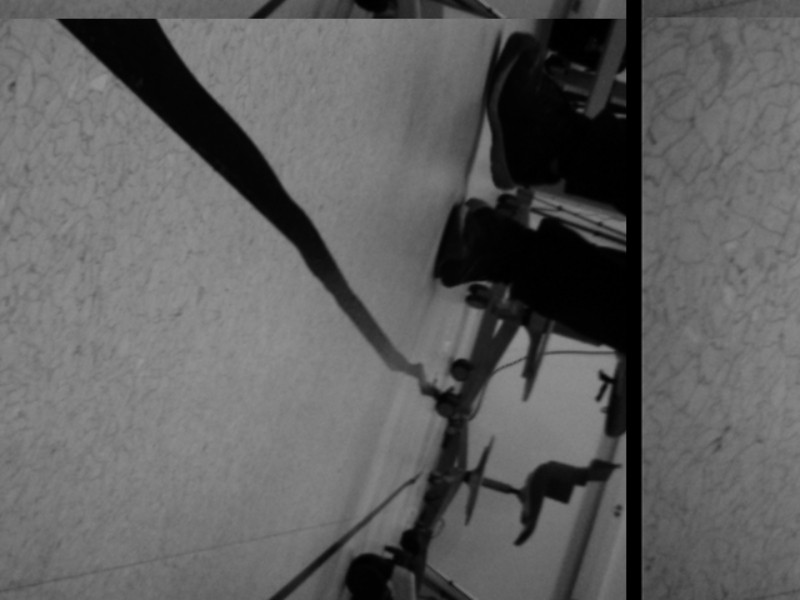

In [ ]:
frame = vdma.readchannel.readframe()
img = Image.fromarray(frame, 'RGB')
display(img)
img.save("img.png")

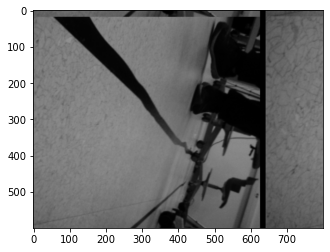

In [ ]:
import cv2  # Import OpenCV
import numpy as np
import matplotlib.pyplot as plt

frame_color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
pixels = np.array(frame_color)
plt.imshow(pixels)
plt.show()


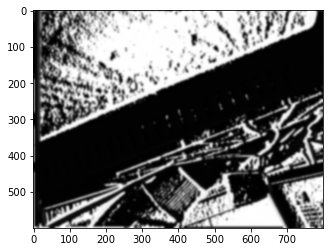

In [ ]:
blur = cv2.GaussianBlur(frame_color,(15,15),0)
pixels = np.array(blur)
plt.imshow(pixels)
plt.show()

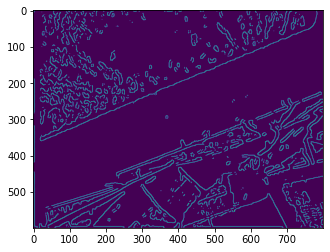

In [ ]:
edges = cv2.Canny(blur,200,200)
pixels = np.array(edges)
plt.imshow(pixels)
plt.show()

In [ ]:
#mask = cv::Mat::zeros(frame.size(), edges.type());
mask = np.zeros(frame.shape[:2], dtype=edges.dtype)

In [ ]:
# Perform bitwise AND operation using the mask and edges (Canny image)
ROI_image = cv2.bitwise_and(edges, edges, mask=mask)

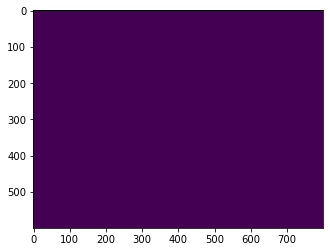

In [ ]:
# Display the result
pixels = np.array(ROI_image)
plt.imshow(pixels)
plt.show()

In [ ]:
import cv2  # Import OpenCV
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# MAIN LOOP

#import cv2
#import numpy as np
#import RPi.GPIO as GPIO
#cap = cv2.VideoCapture(0)
#cap.set(3, 160)
#cap.set(4, 120)

in1 = 4
in2 = 17
in3 = 27
in4 = 22
en1 = 23
en2 = 24
count = 1

###PWM for motor starts from here - autu
base_address_PWM1=0x43C00000
address_range_PWM1=0x10000
duty_cycle_addr_offset_PWM1 = 0x04
pulse_cycle_addr_offset_PWM1 = 0x08
base_address_PWM2=0x43C20000
address_range_PWM2=0x10000
duty_cycle_addr_offset_PWM2 = 0x04
pulse_cycle_addr_offset_PWM2 = 0x08
run_forward_rear = 1570
halt_rear = 1500
run_back_rear = 1405
right = 1100
mid = 1500
left = 1800

mmio_steer = MMIO(base_address_PWM1, address_range_PWM1)
mmio_steer.write(pulse_cycle_addr_offset_PWM1, 1000000)

mmio_gas = MMIO(base_address_PWM2, address_range_PWM2)
mmio_gas.write(pulse_cycle_addr_offset_PWM2, 1000000)

STEER_CTRL = "straight"
STOP_CTRL = "go"


while True:
    frame = vdma.readchannel.readframe()
    low_b = np.uint8([5,5,5])
    high_b = np.uint8([0,0,0])
    mask = cv2.inRange(frame, high_b, low_b)
    contours, hierarchy = cv2.findContours(mask, 1, cv2.CHAIN_APPROX_NONE)
    count = count + 1

    if (STOP_CTRL == "go"):
        mmio_gas.write(duty_cycle_addr_offset_PWM2, run_forward_rear)
    elif (STOP_CTRL == "stop"):
        mmio_gas.write(duty_cycle_addr_offset_PWM2, halt_rear)
    else:
        mmio_gas.write(duty_cycle_addr_offset_PWM2, halt_rear)

    if count > 20:
        count = 0
        pixels = np.array(mask)
        plt.imshow(pixels)
        plt.show()
    if len(contours) > 0 :
        c = max(contours, key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] !=0 :
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            print("CX : "+str(cx)+"  CY : "+str(cy))
            if cx >= 120 :
                print("Turn Left")
                STEER_CTRL = "left"
                mmio_steer.write(duty_cycle_addr_offset_PWM1, left)
            if cx < 120 and cx > 40 :
                print("On Track!")
                mmio_steer.write(duty_cycle_addr_offset_PWM1, mid)
                STEER_CTRL = "straight"
            if cx <=40 :
                print("Turn Right")
                mmio_steer.write(duty_cycle_addr_offset_PWM1, right)
                STEER_CTRL = "right"
            cv2.circle(frame, (cx,cy), 5, (255,255,255), -1)
    else :
        print("I don't see the line")
        #GPIO.output(in1, GPIO.LOW)
        #GPIO.output(in2, GPIO.LOW)
        #GPIO.output(in3, GPIO.LOW)
        #GPIO.output(in4, GPIO.LOW)
    cv2.drawContours(frame, c, -1, (0,255,0), 1)
    #cv2.imshow("Mask",mask)
    #cv2.imshow("Frame",frame)
    if cv2.waitKey(1) & 0xff == ord('q'):   # 1 is the time in ms
        #GPIO.output(in1, GPIO.LOW)
        #GPIO.output(in2, GPIO.LOW)
        #GPIO.output(in3, GPIO.LOW)
        #GPIO.output(in4, GPIO.LOW)
        break
#cap.release()
#cv2.destroyAllWindows()



In [ ]:
###PWM for motor starts from here - autu
base_address_PWM1=0x43C00000
address_range_PWM1=0x10000
duty_cycle_addr_offset_PWM1 = 0x04
pulse_cycle_addr_offset_PWM1 = 0x08

In [ ]:
mmio = MMIO(base_address_PWM1, address_range_PWM1)
mmio.write(pulse_cycle_addr_offset_PWM1, 1000000)

In [1]:
right = 1100
mid = 1500
left = 1800

In [ ]:
for i in range(1,5):
    mmio.write(duty_cycle_addr_offset_PWM1, right)
    sleep(1)
    mmio.write(duty_cycle_addr_offset_PWM1, mid)
    sleep(1)
    mmio.write(duty_cycle_addr_offset_PWM1, left)
    sleep(1)
    mmio.write(duty_cycle_addr_offset_PWM1, mid)
    sleep(1)

In [ ]:
base_address_PWM2=0x43C20000
address_range_PWM2=0x10000
duty_cycle_addr_offset_PWM2 = 0x04
pulse_cycle_addr_offset_PWM2 = 0x08
run_forward_rear = 1570
halt_rear = 1500
run_back_rear = 1405

In [ ]:
run_forward_rear = 1570
halt_rear = 1500
run_back_rear = 1405

In [ ]:
mmio = MMIO(base_address_PWM2, address_range_PWM2)
mmio.write(pulse_cycle_addr_offset_PWM2, 1000000)

In [ ]:
for i in range(1,4):
    mmio.write(duty_cycle_addr_offset_PWM2, halt_rear)
    sleep(2)
    mmio.write(duty_cycle_addr_offset_PWM2, run_back_rear)
    sleep(1)
    mmio.write(duty_cycle_addr_offset_PWM2, halt_rear)
    sleep(2)
    print('rear')

for i in range(1,4):
    mmio.write(duty_cycle_addr_offset_PWM2, halt_rear)
    sleep(2)
    mmio.write(duty_cycle_addr_offset_PWM2, run_forward_rear)
    sleep(1)
    mmio.write(duty_cycle_addr_offset_PWM2, halt_rear)
    sleep(2)
    print('forward')

rear
rear
rear
forward
forward
forward
